# Problem Statement

r/ Askmen and r/Askwomen are 2 subreddits in which redditors post questions towards men and women respectively. However, is there a difference in the type of questions asked towards men and women? Are certain types of questions more likely to be asked in either subreddit? I will attempt to answer these questions, as well as attempt to create a model that can differentiate between the two subreddits.

# Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
import regex as re
import time
import random
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import FunctionTransformer # ...
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.svm import SVC
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 

%matplotlib inline

## Set random state for notebook

In [2]:
np.random.seed(42)

# Scraping data

Before we can begin, we have to get the data from the reddit api. As there is a post limit of 1000 per subreddit, ideally we should have 2000 posts in total.

## url for subreddits in json format, showing 100 posts at a time

In [3]:
askmen_url = 'https://www.reddit.com/r/AskMen/new.json?limit=100'

In [4]:
askwomen_url = 'https://www.reddit.com/r/AskWomen/new.json?limit=100'

As Reddit is basically shutting down all Python scripts from accessing its API, we will change our request a little bit to make it not use the default user agent. 

In [5]:
askmen_res = requests.get(askmen_url, headers={'User-agent': 'Pony Inc 1.0'})

In [6]:
askwomen_res = requests.get(askwomen_url, headers={'User-agent': 'Pony Inc 1.0'})

## Scrape r/ askmen

In [7]:
askmenposts = []
after = None

for a in range(10):
    if after == None:
        current_url = askmen_url
    else:
        current_url = askmen_url + '&after=' + after
    print(current_url)
    res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']]
    askmenposts.extend(current_posts)
    after = current_dict['data']['after']
    
    if a > 0:
        prev_posts = pd.read_csv('askmen.csv')
        current_df = pd.DataFrame(askmenposts)
        
    else:
        pd.DataFrame(askmenposts).to_csv('askmen.csv', index = False)

    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(2,6)
    print(sleep_duration)
    time.sleep(sleep_duration)

## Scrape r/ AskWomen

In [8]:
# askwomenposts = []
# after = None

# for a in range(10):
#     if after == None:
#         current_url = askwomen_url
#     else:
#         current_url = askwomen_url + '&after=' + after
#     print(current_url)
#     res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
    
#     if res.status_code != 200:
#         print('Status error', res.status_code)
#         break
    
#     current_dict = res.json()
#     current_posts = [p['data'] for p in current_dict['data']['children']]
#     askwomenposts.extend(current_posts)
#     after = current_dict['data']['after']
    

#     # generate a random sleep duration to look more 'natural'
#     sleep_duration = random.randint(2,6)
#     print(sleep_duration)
#     time.sleep(sleep_duration)

The two blocks of code above basically loops 10 times to hit the 1000 post limit. Next we need to check how many posts have been scraped

In [9]:
# len(askmenposts) # no. of posts scraped from r/ askmen

In [10]:
# len(askwomenposts) # no. of posts scraped r/ askwomen

After checking the amount of data that has been scraped, it is time to save them.

In [11]:
# pd.DataFrame(askmenposts).to_csv('askmen.csv', index = False)

save scraped askmen posts to csv

In [14]:
# pd.DataFrame(askwomenposts).to_csv('askwomen.csv', index = False)

save scraped askwomen posts to csv

# Create dataframe for reddit title + self text

Because of the nature of the two subreddits,not all posts have self-text. In order to increase the data collected, I have combined the title of the post with the self-text (if any) to create a new column to represent the post.

## Creating dataframe for r/askmen

In [15]:
am_df = pd.read_csv('askmen.csv') 
am_df.head()

,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,...,thumbnail,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],False,NaN,NaN,False,the_teaching_giraffe,NaN,#eb3305,female,"[{'e': 'text', 't': 'Female'}]",...,NaN,"Based your own experience, after how many date...",0,1,https://www.reddit.com/r/AskMen/comments/dl8dl...,[],NaN,False,all_ads,6
1,[],False,NaN,NaN,False,dumb_by_the_ton,NaN,NaN,NaN,[],...,NaN,How can you keep the romance with your SO?,0,1,https://www.reddit.com/r/AskMen/comments/dl83i...,[],NaN,False,all_ads,6
2,[],False,NaN,NaN,False,CinnamonAndCloves,NaN,NaN,NaN,[],...,NaN,What's a good pressure washer?,0,0,https://www.reddit.com/r/AskMen/comments/dl7oc...,[],NaN,False,all_ads,6
3,[],False,NaN,NaN,False,3720-To-One,NaN,NaN,NaN,[],...,NaN,What is your favorite song to fuck to?,0,0,https://www.reddit.com/r/AskMen/comments/dl7js...,[],NaN,False,all_ads,6
4,[],False,NaN,NaN,False,CommandoZach,NaN,NaN,NaN,[],...,NaN,I stupidly judge other men for using umbrellas...,0,0,https://www.reddit.com/r/AskMen/comments/dl7eq...,[],NaN,False,all_ads,6


show orginal_data scraped from askmen

In [16]:
am_df.drop_duplicates('title',inplace=True) #delete rows with repeat titles for askwomen

df1 = am_df[['subreddit','title','selftext']].copy() # copy relevant columns

df1['selftext'].fillna(' ',inplace=True) # replace Nan values 

df1['title_st'] = df1['title'].combine(df1['selftext'], lambda t, s: (t) if s == '' else ((t) + ' ' + (s)))
# combine title and self-text into one column

df1.head()

,subreddit,title,selftext,title_st
0,AskMen,"Based your own experience, after how many date...",Help me settle an argument with my friends! I ...,"Based your own experience, after how many date..."
1,AskMen,How can you keep the romance with your SO?,,How can you keep the romance with your SO?
2,AskMen,What's a good pressure washer?,"I've been wanting one for household stuff, lik...",What's a good pressure washer? I've been wanti...
3,AskMen,What is your favorite song to fuck to?,,What is your favorite song to fuck to?
4,AskMen,I stupidly judge other men for using umbrellas...,,I stupidly judge other men for using umbrellas...


This is the dataframe for titles and self text for r/askmen

## Creating dataframe for r/askwomen

In [17]:
aw_df = pd.read_csv('askwomen.csv')
aw_df.head()

,all_awardings,allow_live_comments,approved_at_utc,approved_by,archived,author,author_cakeday,author_flair_background_color,author_flair_css_class,author_flair_richtext,...,thumbnail,title,total_awards_received,ups,url,user_reports,view_count,visited,whitelist_status,wls
0,[],False,NaN,NaN,False,maianotmia,NaN,NaN,NaN,[],...,NaN,Women who don’t shave your armpits: what deodo...,0,1,https://www.reddit.com/r/AskWomen/comments/dl8...,[],NaN,False,all_ads,6
1,[],False,NaN,NaN,False,Collective1985,NaN,NaN,NaN,[],...,NaN,What's the weirdest name you've heard for brea...,0,1,https://www.reddit.com/r/AskWomen/comments/dl8...,[],NaN,False,promo_adult_nsfw,3
2,[],False,NaN,NaN,False,Sarahlovesminnie,NaN,NaN,NaN,[],...,NaN,What is a beauty feature/practice/standard you...,0,1,https://www.reddit.com/r/AskWomen/comments/dl7...,[],NaN,False,all_ads,6
3,[],False,NaN,NaN,False,invention__,NaN,NaN,NaN,[],...,NaN,What is the nicest thing someone has ever told...,0,1,https://www.reddit.com/r/AskWomen/comments/dl8...,[],NaN,False,all_ads,6
4,[],True,NaN,NaN,False,lolita-cake,NaN,NaN,NaN,[],...,NaN,Women who have had to deal with a non-aggressi...,0,3,https://www.reddit.com/r/AskWomen/comments/dl6...,[],NaN,False,all_ads,6


show original data scraped from askwomen

In [18]:
aw_df.drop_duplicates('title',inplace=True) #delete rows with repeat titles for askwomen

df2 = aw_df[['subreddit','title','selftext']].copy() # copy relevant columns

df2['selftext'].fillna(' ',inplace=True) # replace Nan values

df2['title_st'] = df2['title'].combine(df2['selftext'], lambda t, s: (t) if s == '' else ((t) + ' ' + (s)))
# combine title and self-text into one column

df2.head()

,subreddit,title,selftext,title_st
0,AskWomen,Women who don’t shave your armpits: what deodo...,It would be helpful if you could note whether ...,Women who don’t shave your armpits: what deodo...
1,AskWomen,What's the weirdest name you've heard for brea...,,What's the weirdest name you've heard for brea...
2,AskWomen,What is a beauty feature/practice/standard you...,,What is a beauty feature/practice/standard you...
3,AskWomen,What is the nicest thing someone has ever told...,,What is the nicest thing someone has ever told...
4,AskWomen,Women who have had to deal with a non-aggressi...,,Women who have had to deal with a non-aggressi...


This is the dataframe for titles and self text for r/askwomen

## Combining Dataframes

In [25]:
men_women_df = pd.concat([df1[['subreddit','title_st']],df2[['subreddit','title_st']]])
# only combine subreaddit and combined title/selftext column
men_women_df.head()

,subreddit,title_st
0,AskMen,"Based your own experience, after how many date..."
1,AskMen,How can you keep the romance with your SO?
2,AskMen,What's a good pressure washer? I've been wanti...
3,AskMen,What is your favorite song to fuck to?
4,AskMen,I stupidly judge other men for using umbrellas...


This is the new dataframe containing posts from both r/askmen and r/askwomen

In [26]:
men_women_df['title_st'] = men_women_df['title_st'].str.lower()
men_women_df.head()

,subreddit,title_st
0,AskMen,"based your own experience, after how many date..."
1,AskMen,how can you keep the romance with your so?
2,AskMen,what's a good pressure washer? i've been wanti...
3,AskMen,what is your favorite song to fuck to?
4,AskMen,i stupidly judge other men for using umbrellas...


lowercase the title/self text

## Cleaning the dataset

The data that we have has plenty of unneccessary data (symbols, emoticons, punctuations , etc.). In addition, we also need to preprocess the words via lemmatization or stemming. Functions for these steps will be created below

### Spacy Lemmatization + cleaning function

spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It is a more advanced library for NLP than NLTK and as such, I will be using spacy to lemmatize the text.

In [27]:
def spacy_cleaning_function_lemm(text):
    nlp = spacy.load("en", disable=['ner', 'tagger', 'parser', 'textcat'])
    # as spacy take a VERY long time to preprocess data, unneeded functions in the pipeline are disabled
    text.strip()
    text = re.sub("[^a-zA-Z0-9']+"," ",text) #keep only alphabets and numbers and '
    
    
    doc = nlp(text)
    spacy_lemmatized_words = [token.lemma_ for token in doc]

    return ' '.join(spacy_lemmatized_words)

In [28]:
# men_women_df['spacy_lemmatized_title'] = men_women_df.title_st.apply(spacy_cleaning_function_lemm)
# men_women_df.head()

,subreddit,title_st,spacy_lemmatized_title
0,AskMen,"based your own experience, after how many date...",base your own experience after how many date c...
1,AskMen,how can you keep the romance with your so?,how can you keep the romance with your so
2,AskMen,what's a good pressure washer? i've been wanti...,what have a good pressure washer -PRON- have b...
3,AskMen,what is your favorite song to fuck to?,what be your favorite song to fuck to
4,AskMen,i stupidly judge other men for using umbrellas...,i stupidly judge other man for use umbrella be...


In [29]:
# men_women_df['target'] = men_women_df['subreddit'].map({'AskMen':0, 'AskWomen':1})
# men_women_df.head()

,subreddit,title_st,spacy_lemmatized_title,target
0,AskMen,"based your own experience, after how many date...",base your own experience after how many date c...,0
1,AskMen,how can you keep the romance with your so?,how can you keep the romance with your so,0
2,AskMen,what's a good pressure washer? i've been wanti...,what have a good pressure washer -PRON- have b...,0
3,AskMen,what is your favorite song to fuck to?,what be your favorite song to fuck to,0
4,AskMen,i stupidly judge other men for using umbrellas...,i stupidly judge other man for use umbrella be...,0


In [30]:
# men_women_df.to_csv('clean_titles.csv')

In [77]:
men_women_df = pd.read_csv('clean_titles.csv')
men_women_df.head()

,Unnamed: 0,subreddit,title_st,spacy_lemmatized_title,target
0,0,AskMen,"based your own experience, after how many date...",base your own experience after how many date c...,0
1,1,AskMen,how can you keep the romance with your so?,how can you keep the romance with your so,0
2,2,AskMen,what's a good pressure washer? i've been wanti...,what have a good pressure washer -PRON- have b...,0
3,3,AskMen,what is your favorite song to fuck to?,what be your favorite song to fuck to,0
4,4,AskMen,i stupidly judge other men for using umbrellas...,i stupidly judge other man for use umbrella be...,0


# EDA

Now the the data is clean and pre-processed, it is time to look at the text in the subreddits.

## Create Function to make Wordcloud/ barcharts

In [32]:
def wc_and_freq_generator(df,target_col,text_col,more_stops = ['']): 
    # (datframe, column name of target, column name of text, additional stopwords to add)
    
    string1 = ''
    for i in df.loc[df[target_col]==0][text_col]:
        if i:
            string1 += f'{i} ' # string of all askmen posts
    
    
    string2 = ''
    for i in df.loc[df[target_col]==1][text_col]:
        if i:
            string2 += f'{i} ' # string of all askwomen posts

    fig, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2,2,sharey='row', figsize=(30,15))
    
    plt.suptitle('AskMen vs AskWomen', fontsize=30);
    
    StopWords = set(stopwords.words('english'))
    [StopWords.add(word) for word in more_stops]

    wc1 = WordCloud(
        width=1600,
        height=800,
        max_words=50,
        background_color="white",
        relative_scaling=1,
        stopwords=StopWords,
        ).generate(string1)

    ax1.axis('off')
    ax1.set_title('AskMen WordCloud', fontsize=25)

    ax1.imshow(wc1); #wordcloud for target 0 (askmen)
    
    
    CV_man = CountVectorizer(max_features=20, ngram_range= (1,2), stop_words= StopWords,analyzer='word', lowercase=False)
    tokenized_man = CV_man.fit_transform(df.loc[df[target_col]==0][text_col])
    # ^ sparse matrix of top 20 words of target 0 (askmen)
    
    CV_man.get_feature_names()
    tokenized_man_df = pd.DataFrame(tokenized_man.todense(),columns=CV_man.get_feature_names())
    
    # ^ convert sparse matrix of top 20 words of target 0 (askmen) to df
    tokenized_man_df.sum().sort_values(ascending=False).plot.bar(ax = ax2)
    ax2.set_title('AskMen Word Frequency',fontsize=25)
    
    ax2.tick_params(labelsize=20) #barchart for target 0 (askmen)
    
    wc2 = WordCloud(
        width=1600,
        height=800,
        max_words=50,
        background_color="white",
        relative_scaling=1,
        stopwords=StopWords,
        ).generate(string2)

    ax3.axis('off')
    ax3.set_title('AskWomen WordCloud', fontsize=25)

    ax3.imshow(wc2); #wordcloud for target 1 (askwomen)
    
    
    CV_woman = CountVectorizer(max_features=20, ngram_range= (1,2), stop_words= StopWords,analyzer='word', lowercase=False)
    tokenized_woman = CV_woman.fit_transform(df.loc[df[target_col]==1][text_col])
    # ^ sparse matrix of top 20 words of target 1 (askwomen)
    
    CV_woman.get_feature_names()
    tokenized_woman_df = pd.DataFrame(tokenized_woman.todense(),columns=CV_woman.get_feature_names())
    # ^ convert sparse matrix of top 20 words of target 1 (askwomen) to df
    
    tokenized_woman_df.sum().sort_values(ascending=False).plot.bar(ax = ax4)
    ax4.set_title('AskWomen Frequency',fontsize=25)
    
    ax4.tick_params(labelsize=20) #barchart for target 1 (askwomen)
    


## Most common words in each subreddit

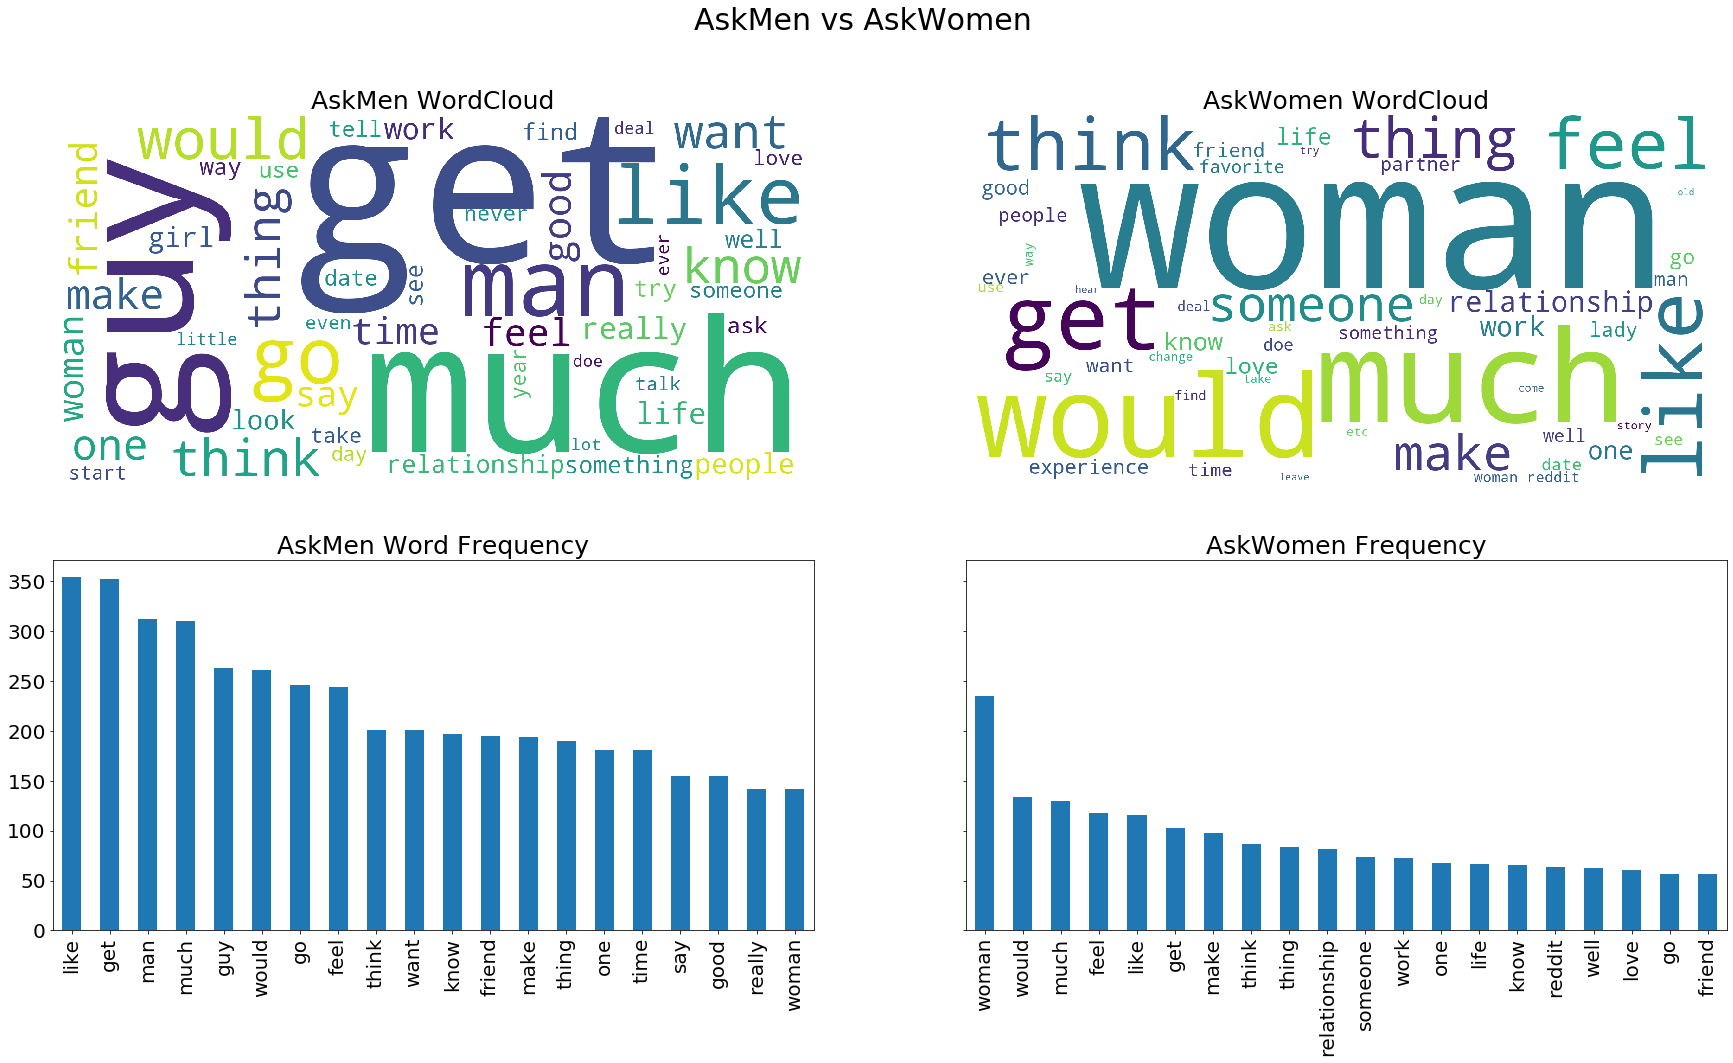

In [33]:
wc_and_freq_generator(men_women_df,'target','spacy_lemmatized_title',['PRON'])

There seems to be alot of overlap in the words used in each subreddit post. The following graphs are the wordcloud/barcharts with these words removed

## Most common words in each subreddit after removing overlap in top 20 words

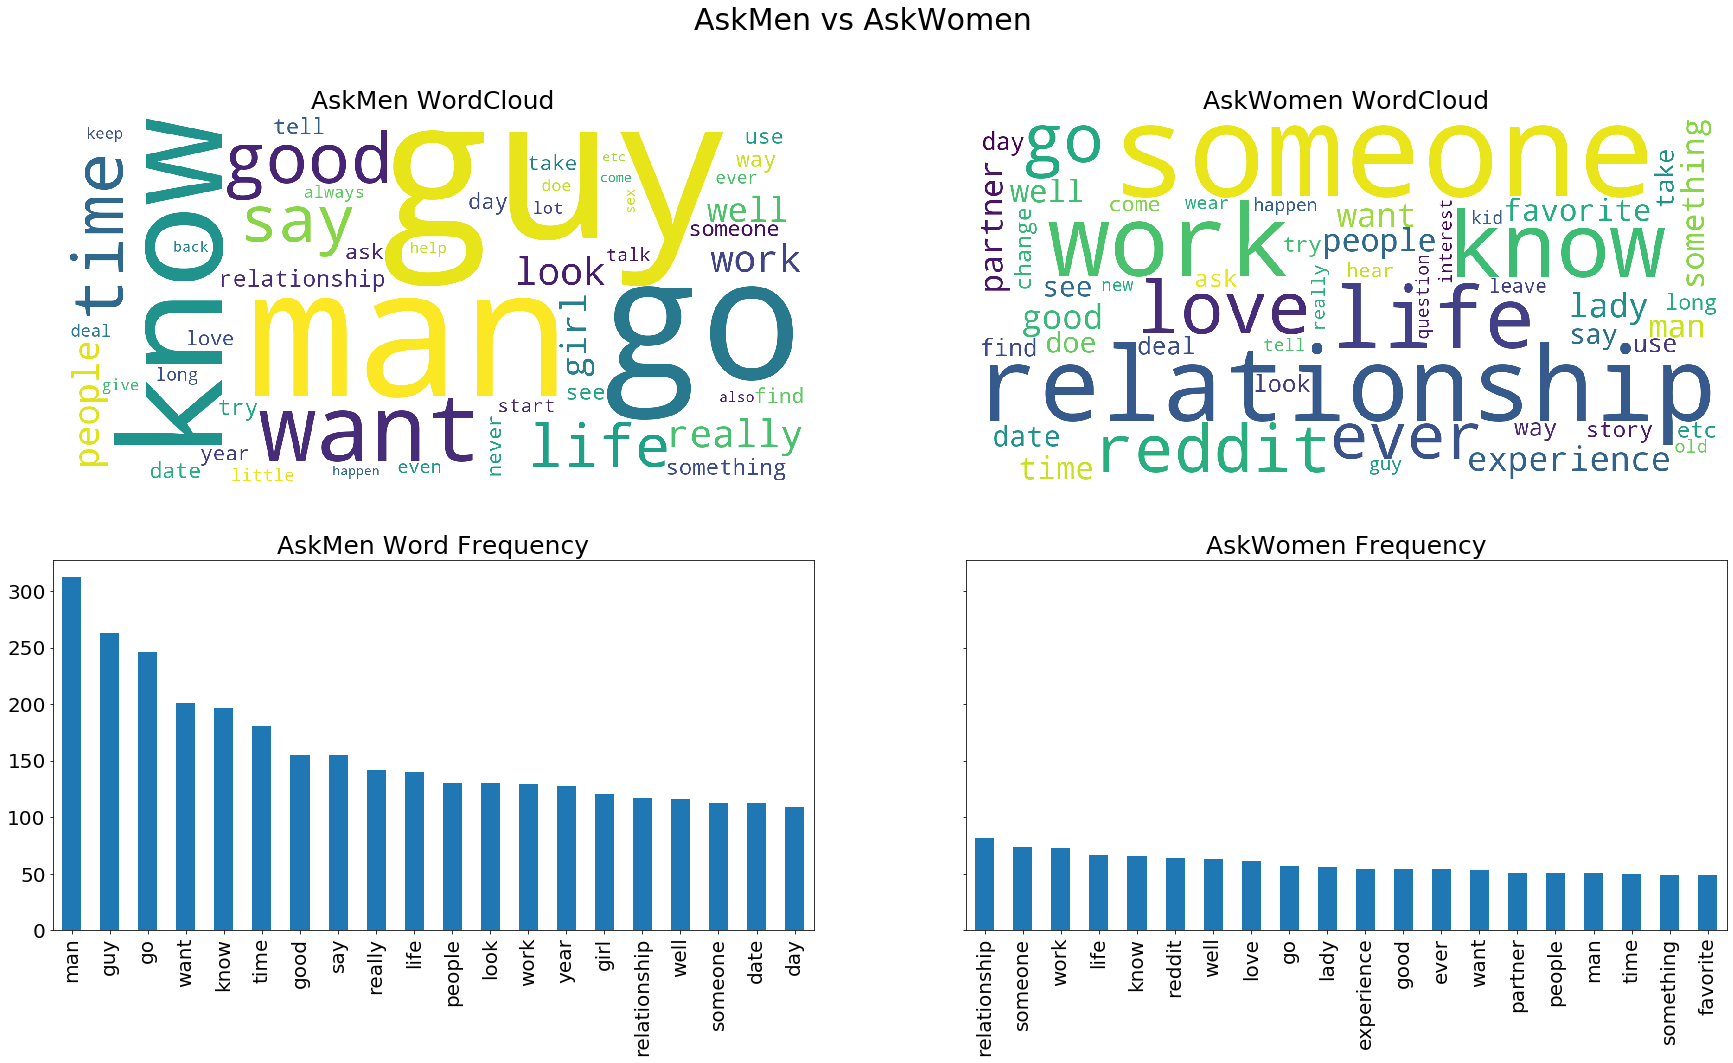

In [34]:
wc_and_freq_generator(men_women_df,'target','spacy_lemmatized_title',['PRON','like','get', 'much','would',
                                                                      'feel', 'think', 'friend', 'make', 'thing', 'one', 
                                                                      'woman'])

## Intepretation of EDA

Examining the graphs show that the words: 'like','get','much','would', 'feel', 'think', 'friend', 'make', 'thing', 'one' and 'woman' are seen alot in both subreddits.   

Notably, With the exception of 'woman', these words are seen alot more in r/ askmen than askwomen. In addition, after removing the words above. many of the new top words in Askwomen seem to be specific to askwomen while the new top words in askmen also appear in askwomen.

# Modelling

A few models will be used to classify posts between askmen and askwomen, and the best model will be selected.

## Split train & test set

In [38]:
s_lemm_X = men_women_df['spacy_lemmatized_title']
y = men_women_df['target']

In [40]:
s_lemm_X_train, s_lemm_X_test,y_train, y_test = train_test_split(s_lemm_X, y, train_size =0.8,
                                                                                         random_state=42,stratify = y)

## Create Model Assessment function

After creating the model, we need some way to assess it. This function will plot an roc curve as well as the confusion matrix annd accuracy score for each model

In [41]:
def model_assessor(model, X_test, y_test):
    '''
    Plots an ROC, with AUC score and other relevant metrics
    '''
    predictions = model.predict(X_test)
    confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    accuracy = (tn+tp)/(tn+ fp+ fn+ tp)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    
    
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    # points of the ROC
    roc_auc = auc(fpr, tpr)
    # calculate AUC score
    

    fig = plt.figure(figsize=(12,7))
    plt.plot(fpr, tpr, 'b', label = f'AUC = {round(roc_auc,2)}')

    plt.plot([0, 1], [0, 1], color ='red', label='baseline',
             linestyle='--')
    plt.legend(loc = 'lower right',fontsize=15)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=15)
    plt.title('Receiver Operating Characteristic',fontsize=15)
    plt. text(0.5, 0.2, 
              f'''
              True Negatives: {tn}
              False Positives: {fp}
              False Negatives: {fn}
              True Positives: {tp}
              
              accuracy: {accuracy}
              recall: {recall}
              specificity: {specificity}
              precision: {precision}
              '''
              , horizontalalignment='center', verticalalignment='center',fontsize = 13)
    #show accuracy, recall, specificity, precision and confusion matrix on the graph
    plt.show()

Now various models will be used to classify the two subreddit posts

## Stopwords

Stopwords are words that add little meaning to a sentence. In addition, we might want to add in words that are not currently stopwords. A few sets of stopwords will be initialized to see which set provides the most accurate model

In [42]:
StopWords_1 = stopwords.words('english')

StopWords_2 = list(stopwords.words('english'))
StopWords_2.extend(['woman','man'])

StopWords_3 = ['woman','man'] 


In [43]:
print(StopWords_1)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Model Testing

Multinomial Naive Bayes will be used as a baseline model for the classification task. As this is the first model, more features will be tested in the GridSearch.

### TfidfVec, MultinomialNB

In [44]:
TfidfV_pipe = Pipeline([('Tfidfvec', TfidfVectorizer()),
                                        ('NBm', MultinomialNB())])

TfidfV_pipe_param = {
    'Tfidfvec__max_features': [1000, 2000, 3000],
    'Tfidfvec__min_df': [1, 2, 3],
    'Tfidfvec__max_df': [.6,.7,.8],
    'Tfidfvec__ngram_range': [(1,1), (1,2)],
    'Tfidfvec__stop_words' : [None, StopWords_1, StopWords_2, StopWords_3],
    'Tfidfvec__use_idf' : [True, False] 
}
mnbgs = GridSearchCV(TfidfV_pipe,param_grid=TfidfV_pipe_param, cv=5, n_jobs=-1)

In [45]:
mnbgs.fit(s_lemm_X_train,y_train);

In [46]:
mnbgs.best_params_

{'Tfidfvec__max_df': 0.8,
 'Tfidfvec__max_features': 1000,
 'Tfidfvec__min_df': 3,
 'Tfidfvec__ngram_range': (1, 2),
 'Tfidfvec__stop_words': None,
 'Tfidfvec__use_idf': True}

It seems that the model scores the best when no stopwords are used. In addition, the model also performs better using TFIDF rather than just TF. Therefore all future models will not use any stopwords and will use TFIDF.

In [47]:
print(f'train score: {mnbgs.score(s_lemm_X_train,y_train)}')
print(f'test score: {mnbgs.score(s_lemm_X_test,y_test)}')


train score: 0.798234552332913
test score: 0.7304785894206549


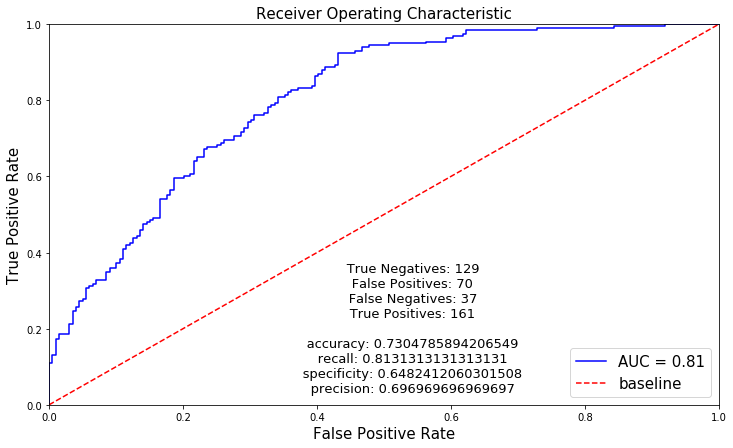

In [48]:
model_assessor(mnbgs,s_lemm_X_test,y_test)

### TfidfVec, LogReg

In [49]:
log_TfidfV_pipe = Pipeline([('tfidfvec', TfidfVectorizer()),
                                        ('Lr', LogisticRegression(penalty='l2'))])
# ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate=True)),
# MultinomialNB(class_prior=[0.5, 0.5])
TfidfV_pipe_param = {
    'tfidfvec__max_features': [500, 1000, 2000],
    'tfidfvec__min_df': [1, 2, 3],
    'tfidfvec__max_df': [.6,.7,.8],
    'tfidfvec__ngram_range': [(1,1), (1,2)]
}
lgs = GridSearchCV(log_TfidfV_pipe,param_grid=TfidfV_pipe_param, cv=5,n_jobs=-1)

In [50]:
lgs.fit(s_lemm_X_train,y_train);

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [51]:
lgs.best_params_

{'tfidfvec__max_df': 0.8,
 'tfidfvec__max_features': 1000,
 'tfidfvec__min_df': 1,
 'tfidfvec__ngram_range': (1, 1)}

In [52]:
print(f'train score: {lgs.score(s_lemm_X_train,y_train)}')
print(f'test score: {lgs.score(s_lemm_X_test,y_test)}')

train score: 0.8240857503152585
test score: 0.7304785894206549


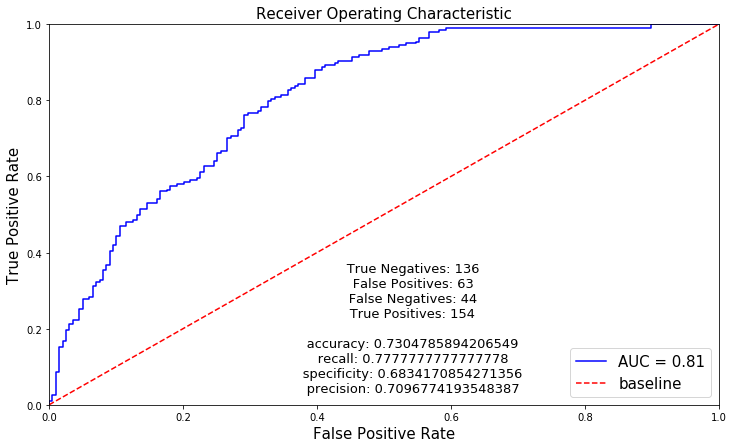

In [53]:
model_assessor(lgs,s_lemm_X_test,y_test)

### TfidfVec, RandomForest

In [54]:
rf_TfidfV_pipe = Pipeline([('tfidfvec', TfidfVectorizer()),
                                        ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state = 42))])

TfidfV_pipe_param = {
    'tfidfvec__max_features': [2000,2500,3000],
    'tfidfvec__min_df': [1, 2, 3],
    'tfidfvec__max_df': [.5,.6],
    'tfidfvec__ngram_range': [(1,1), (1,2)],
    'rf__min_samples_split' : [3,4]
}
rfgs = GridSearchCV(rf_TfidfV_pipe ,param_grid=TfidfV_pipe_param, cv=5,n_jobs=-1)


In [55]:
rfgs.fit(s_lemm_X_train,y_train);

In [56]:
rfgs.best_params_

{'rf__min_samples_split': 3,
 'tfidfvec__max_df': 0.5,
 'tfidfvec__max_features': 2500,
 'tfidfvec__min_df': 1,
 'tfidfvec__ngram_range': (1, 1)}

In [57]:
print(f'train score: {rfgs.score(s_lemm_X_train,y_train)}')
print(f'test score: {rfgs.score(s_lemm_X_test,y_test)}')

train score: 0.9962168978562421
test score: 0.7204030226700252


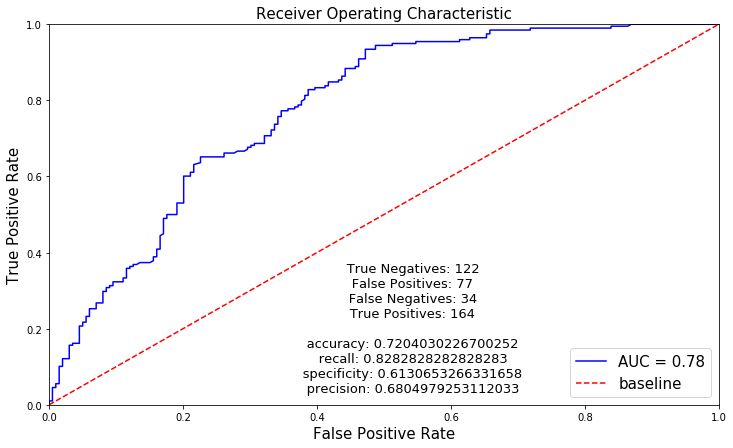

In [58]:
model_assessor(rfgs,s_lemm_X_test,y_test)

### TfidfVec, AdaBoost

In [59]:
ada_TfidfV_pipe = Pipeline([('tfidfvec', TfidfVectorizer()),
                                        ('ada', AdaBoostClassifier())])

TfidfV_pipe_param = {
    'tfidfvec__max_features': [1000, 2000, 3000],
    'tfidfvec__min_df': [1, 2],
    'tfidfvec__max_df': [.5,.6,.7,.8],
    'tfidfvec__ngram_range': [(1,1), (1,2)],
    'ada__n_estimators' : [10,20,],
    
}
adags = GridSearchCV(ada_TfidfV_pipe,param_grid=TfidfV_pipe_param, cv=5, n_jobs=-1)

In [60]:
adags.fit(s_lemm_X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidfvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

In [61]:
adags.best_params_

{'ada__n_estimators': 20,
 'tfidfvec__max_df': 0.5,
 'tfidfvec__max_features': 2000,
 'tfidfvec__min_df': 2,
 'tfidfvec__ngram_range': (1, 2)}

In [62]:
print(f'train score: {adags.score(s_lemm_X_train,y_train)}')
print(f'test score: {adags.score(s_lemm_X_test,y_test)}')

train score: 0.7477931904161412
test score: 0.7178841309823678


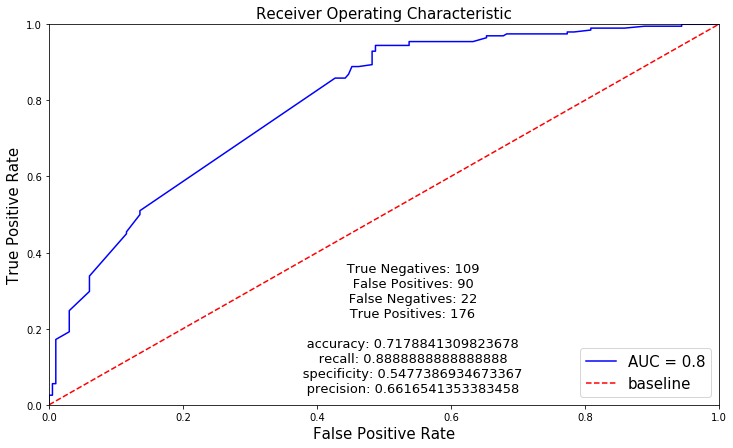

In [63]:
model_assessor(adags,s_lemm_X_test,y_test)

### TfidfVec, Support Vector Machines

In [64]:
svc_TfidfV_pipe = Pipeline([('tfidfvec', TfidfVectorizer()),
                                        ('svc', SVC(gamma = 'scale', probability = True , kernel = "rbf", random_state = 42))])

TfidfV_pipe_param = {
    'tfidfvec__max_features': [1000, 2000, 3000],
    'tfidfvec__min_df': [1, 2],
    'tfidfvec__max_df': [.5,.6,.7,.8],
    'tfidfvec__ngram_range': [(1,1), (1,2)],
    'svc__C' : [10],
    
}
svcgs = GridSearchCV(svc_TfidfV_pipe,param_grid=TfidfV_pipe_param, cv=5, n_jobs=-1)

In [65]:
svcgs.fit(s_lemm_X_train,y_train);

In [66]:
svcgs.best_params_

{'svc__C': 10,
 'tfidfvec__max_df': 0.5,
 'tfidfvec__max_features': 3000,
 'tfidfvec__min_df': 2,
 'tfidfvec__ngram_range': (1, 2)}

In [67]:
print(f'train score: {svcgs.score(s_lemm_X_train,y_train)}')
print(f'test score: {svcgs.score(s_lemm_X_test,y_test)}')


train score: 0.9968474148802018
test score: 0.7329974811083123


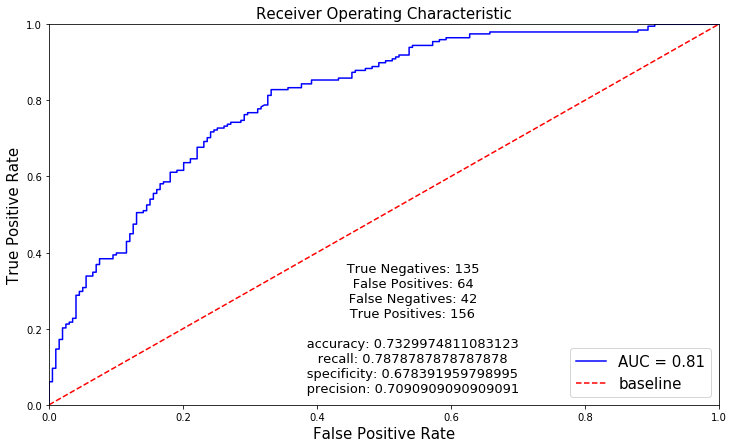

In [68]:
model_assessor(svcgs,s_lemm_X_test,y_test)

## Comparing the models

Now that the models have been created, its time to compare them

In [69]:
def compare_models(models): # input list of models

    to_df = []

    for model in models:

        tn, fp, fn, tp = confusion_matrix(y_test,model.predict(s_lemm_X_test)).ravel()

        accuracy = (tn+tp)/(tn+ fp+ fn+ tp)
        recall = tp/(tp+fn)
        specificity = tn/(tn+fp)
        precision = tp/(tp+fp)

        to_df.append([tn,fp,fn,tp,accuracy,recall,specificity,precision])

    df = pd.DataFrame(to_df,columns = ['TN','FP','FN','TP','accuracy','recall','specificity','precision'])   
        
    return df

In [70]:
model_comparison_df = compare_models([mnbgs,lgs,rfgs,adags,svcgs])
model_comparison_df.rename(index={0:'Naive Bayes', 1:'Log Regression', 2:'Random Forest', 3: 'AdaBoost', 4:'Support Vector Machines'})

,TN,FP,FN,TP,accuracy,recall,specificity,precision
Naive Bayes,129,70,37,161,0.730479,0.813131,0.648241,0.696970
Log Regression,136,63,44,154,0.730479,0.777778,0.683417,0.709677
Random Forest,122,77,34,164,0.720403,0.828283,0.613065,0.680498
AdaBoost,109,90,22,176,0.717884,0.888889,0.547739,0.661654
Support Vector Machines,135,64,42,156,0.732997,0.787879,0.678392,0.709091


### Which is the best model?

The accuracy of each model is simillar. However, there are greater differences in recall and specificity.  
AdaBoost has the highest recall (correctly classifying Askwomen) while Log Regression has better specificity (better at classfying Askmen)  

In all models, Recall is higher than specificity and the True positives are higher than True negatives. This means that the model finds it easier to correctly classify r/ Askwomen than r/ Askmen. 

Each model has its own strengths and weakness and therefore it is hard to pick a best model.

## Creating an Ensemble model

Since every model has its own strengths, I will attempt to aggregate the scores for each model and see the result.

In [71]:
ensemble_predict = pd.DataFrame([mnbgs.predict(s_lemm_X_test),lgs.predict(s_lemm_X_test), rfgs.predict(s_lemm_X_test), adags.predict(s_lemm_X_test), svcgs.predict(s_lemm_X_test)], index=['NB','LogReg','RandF','ADA','SupVec']).T

In [72]:
ensemble_predict['mean_predict'] = (ensemble_predict['NB'] + ensemble_predict['LogReg'] + ensemble_predict['RandF'] + ensemble_predict['SupVec'] + ensemble_predict['ADA'])/5
ensemble_predict.head()

,NB,LogReg,RandF,ADA,SupVec,mean_predict
0,1,1,1,1,1,1.0
1,0,0,0,0,0,0.0
2,0,0,0,1,0,0.2
3,0,0,0,0,0,0.0
4,1,1,1,1,1,1.0


In [73]:
ensemble_predict['mean_predict'] = ensemble_predict['mean_predict'].apply(lambda x: 1 if x >0.5 else 0)
ensemble_predict.head()

,NB,LogReg,RandF,ADA,SupVec,mean_predict
0,1,1,1,1,1,1
1,0,0,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,0,0,0
4,1,1,1,1,1,1


In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_predict['mean_predict']).ravel()
print(f"True Negatives: {tn}") #correctly predicted askmen
print(f"False Positives: {fp}") #wrongly predicted askwomen
print(f"False Negatives: {fn}") #wrongly predicted askmen
print(f"True Positives: {tp}") #correctly predicted askwomen
print()
accuracy = (tn+tp)/(tn+ fp+ fn+ tp)
recall = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print(f'accuracy: {accuracy}')
print(f'recall: {recall}')
print(f'specificity: {specificity}')
print(f'precision: {precision}')

True Negatives: 131
False Positives: 68
False Negatives: 30
True Positives: 168

accuracy: 0.7531486146095718
recall: 0.8484848484848485
specificity: 0.6582914572864321
precision: 0.711864406779661


This has led to a small increase in accuracy

# Limitations and reasons for misclassification

Some reasons why for misclassication include:
- unable to seperate post that lack the keywords that are best able to classify subreddits. 
- Bag of words approach, loses context

## What are the types of posts that are likely to be misclassified?

The wordclouds below show the words that occur the most often in misclassified words.

### Top words in wrongly classified Askmen posts

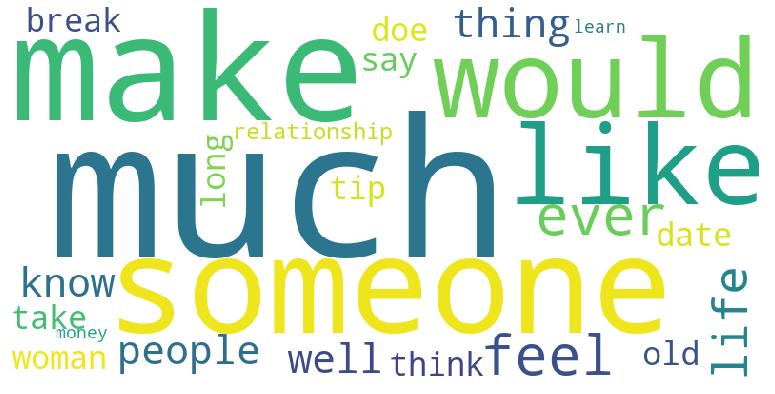

In [75]:
a_string = ''
for x,y,z in zip(ensemble_predict['mean_predict'],y_test, s_lemm_X_test):
    if y == 0:
        if x != y:
            a_string += f'{z} '

StopWords = set(stopwords.words('english'))
StopWords.add('PRON')
            
plt.figure(figsize=(15,7))
wc = WordCloud(
    width=800,
    height=400,
    max_words=25,
    background_color="white",
    relative_scaling=1,
    stopwords=StopWords).generate(a_string)
plt.axis('off')


plt.imshow(wc);    

### Top words in wrongly classified Askwomen posts

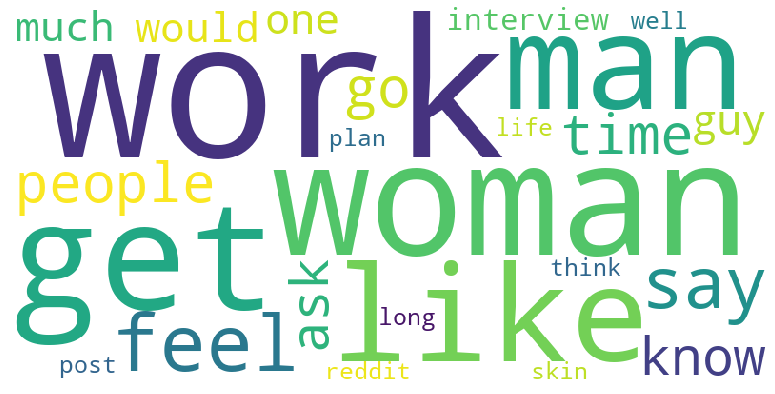

In [76]:
b_string = ''
for x,y,z in zip(ensemble_predict['mean_predict'],y_test, s_lemm_X_test):
    if y == 1:
        if x != y:
            b_string += f'{z} '

StopWords = set(stopwords.words('english'))
StopWords.add('PRON')
            
plt.figure(figsize=(15,7))
wc = WordCloud(
    width=800,
    height=400,
    max_words=25,
    background_color="white",
    relative_scaling=1,
    stopwords=StopWords).generate(b_string)
plt.axis('off')


plt.imshow(wc);    

As we can see, the top words in misclassfied posts are contain words that often appear in the other posts, highlighting the weakness of the bag of words approach.


# Conclusion

The models produced above are some what able to differentiate between r/askmen and r/askwomen.  Looking at the word clouds seems to suggest that the posts in r/askwomen seem to be related to women or relationships, while in r/askmen, although most of the posts are related to men/guys, the top few words are words that are also fairly common in r/askwomen.  

This seems to suggest that although there are some types of posts that are unique to r/askmen, the posts there use very general words. Both posts ask for opinions for advice (eg. what do you like..., what do you think..., what is one thing that makes you..) but most of the posts in Askwomen are related to makeup or relationships and posts in askmen that contain these words are more likely to be misclassified.  

Perhaps in the future a learning method that captures context would be a more accurate way to classfy posts.